In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import matplotlib.pyplot as plt
import numpy as np
import os
# import pandas as pd

2023-06-10 19:28:01.079546: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Dataset preparation

### Set parameters

In [2]:
batch_size = 32
img_height = 184
img_width = 216
img_size = (img_height, img_width)
img_shape = img_size + (3,)

### Load dataset

In [3]:
from tensorflow.keras.utils import image_dataset_from_directory

train_path = "/drive0-storage/Gracia/dataset_5/training"
val_path = "/drive0-storage/Gracia/dataset_5/validation"

with tf.device("CPU"):
    train_ds = image_dataset_from_directory(train_path,
                                        seed = 123,
                                        image_size = img_size,
                                        batch_size = batch_size)
    
    val_ds = image_dataset_from_directory(val_path,
                                      seed = 456,
                                      image_size = img_size,
                                      batch_size = batch_size)

2023-06-10 19:28:03.423014: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-10 19:28:03.968205: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1637] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7910 MB memory:  -> device: 0, name: A100-SXM4-40GB MIG 2g.10gb, pci bus id: 0000:90:00.0, compute capability: 8.0


Found 16332 files belonging to 3 classes.
Found 4080 files belonging to 3 classes.


In [4]:
# os.rmdir("/drive0-storage/Gracia/dataset_1/.ipynb_checkpoints")

In [5]:
class_names = train_ds.class_names
num_classes = len(class_names)

print(class_names)

['bipolar_disorder', 'healthy_controls', 'schizophrenia']


<dtype: 'float32'>
0.0 244.96414
(184, 216, 3)


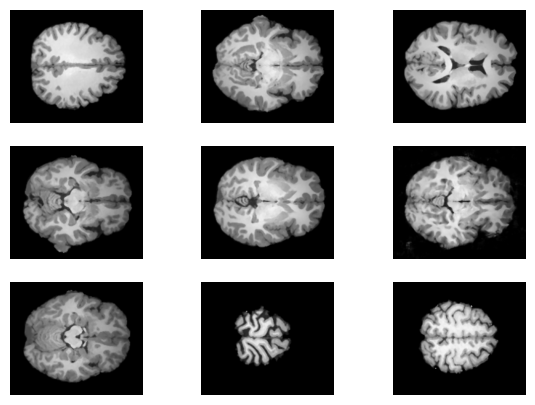

In [6]:
with tf.device("CPU"):
    plt.figure(figsize=(7,5))
    for images, labels in train_ds.take(1):
        org_image = images[0]
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.axis("off")

    print(org_image.dtype)
    print(np.min(org_image), np.max(org_image))
    print(org_image.shape)

### Test set

In [7]:
with tf.device("CPU"):
    val_batches = tf.data.experimental.cardinality(val_ds)
    test_dataset = val_ds.take(val_batches // 2)
    validation_dataset = val_ds.skip(val_batches // 2)
    
    # Buffered prefetching
    AUTOTUNE = tf.data.AUTOTUNE
    train_dataset = train_ds.prefetch(buffer_size = AUTOTUNE)
    validation_dataset = validation_dataset.prefetch(buffer_size = AUTOTUNE)
    test_dataset = test_dataset.prefetch(buffer_size = AUTOTUNE)

In [ ]:
print(len(validation_dataset))
print(len(test_dataset))

## Model building

In [8]:
def build_vgg16():
    model = Sequential()
    
    # Block 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=img_shape))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 4
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 5
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Flatten the output and create fully connected layers
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))  
    
    return model

In [9]:
with tf.device("GPU"):
    vgg16 = build_vgg16()

    # add rescale layer, chain model
    rescale = tf.keras.layers.Rescaling(1./255)
    inputs = tf.keras.Input(shape = img_shape)
    x = rescale(inputs)
    outputs = vgg16(x)
    model = tf.keras.Model(inputs,outputs) 
    
    # compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-5),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
                  metrics=['accuracy'])

## Model training

In [10]:
# Callback function
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.99):
            print("\nReached 99% accuracy, cancelling training")
            self.model.stop_training = True
            
callbacks = myCallback()
save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
checkpoints_cb = tf.keras.callbacks.ModelCheckpoint('./cnn5_checkpoints', options=save_locally)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

In [11]:
EPOCH = 25

history = model.fit(
            train_dataset,
            validation_data = validation_dataset,
            epochs = EPOCH,
            batch_size = 32,
            callbacks=[callbacks])

Epoch 1/25


2023-06-10 19:28:15.344513: I tensorflow/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-06-10 19:28:16.646556: I tensorflow/stream_executor/cuda/cuda_blas.cc:1633] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


511/511 [==============================] - 90s 167ms/step - loss: 1.0959 - accuracy: 0.3526 - val_loss: 1.1177 - val_accuracy: 0.3514
Epoch 2/25
511/511 [==============================] - 84s 165ms/step - loss: 0.9943 - accuracy: 0.4919 - val_loss: 1.0924 - val_accuracy: 0.4257
Epoch 3/25
511/511 [==============================] - 84s 164ms/step - loss: 0.8755 - accuracy: 0.5778 - val_loss: 1.0472 - val_accuracy: 0.4783
Epoch 4/25
511/511 [==============================] - 84s 164ms/step - loss: 0.7942 - accuracy: 0.6292 - val_loss: 0.9929 - val_accuracy: 0.5064
Epoch 5/25
511/511 [==============================] - 84s 164ms/step - loss: 0.7187 - accuracy: 0.6663 - val_loss: 0.9934 - val_accuracy: 0.5364
Epoch 6/25
511/511 [==============================] - 84s 164ms/step - loss: 0.6561 - accuracy: 0.7029 - val_loss: 0.9065 - val_accuracy: 0.5842
Epoch 7/25
511/511 [==============================] - 84s 164ms/step - loss: 0.5882 - accuracy: 0.7357 - val_loss: 0.8728 - val_accuracy: 0.5

In [18]:
model.save('./models/cnn5_25epoch.h5')

### Training evaluation

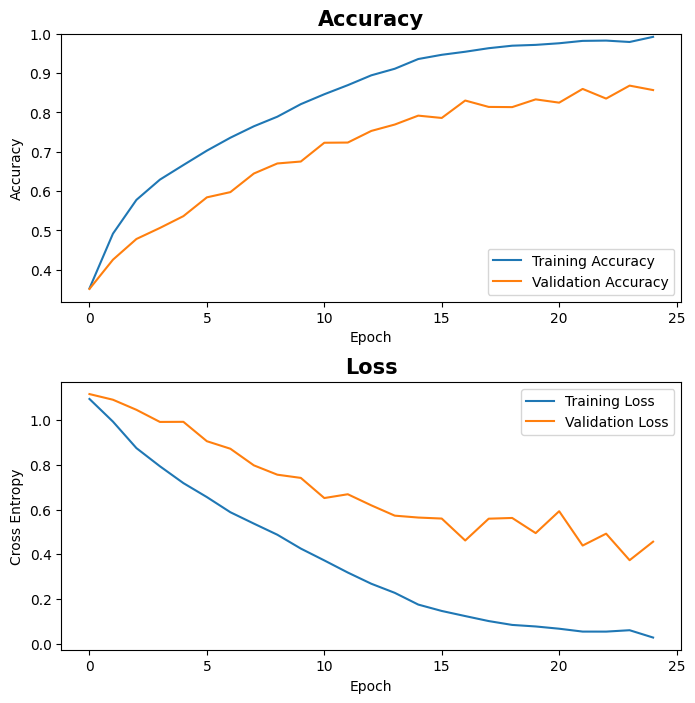

In [13]:
plt.figure(figsize=(8, 8))

# training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim([min(plt.ylim()),1])
plt.title('Accuracy', size=15, fontweight='bold')

# training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
# plt.ylim([0,1.0])
plt.title('Loss', size=15, fontweight='bold')

plt.subplots_adjust(hspace=0.3)
plt.show()

In [19]:
acc

[0.3526206314563751,
 0.49185648560523987,
 0.5777614712715149,
 0.6291942000389099,
 0.6662992835044861,
 0.7028533220291138,
 0.7357335090637207,
 0.7647563219070435,
 0.7891256213188171,
 0.8210262060165405,
 0.8461915254592896,
 0.8692750334739685,
 0.8942566514015198,
 0.9109722971916199,
 0.9357090592384338,
 0.9464241862297058,
 0.9542003273963928,
 0.963201105594635,
 0.9695689678192139,
 0.9716507196426392,
 0.975753128528595,
 0.9818148612976074,
 0.9825496077537537,
 0.9789983034133911,
 0.9920401573181152]

In [20]:
val_acc

[0.3513779640197754,
 0.4256889820098877,
 0.47834646701812744,
 0.5063976645469666,
 0.5364173054695129,
 0.5841535329818726,
 0.5974409580230713,
 0.6446850299835205,
 0.6702755689620972,
 0.6751968264579773,
 0.7229330539703369,
 0.7234252095222473,
 0.7529527544975281,
 0.7691929340362549,
 0.7918307185173035,
 0.7859252095222473,
 0.8302165269851685,
 0.8139764070510864,
 0.813484251499176,
 0.8331692814826965,
 0.8248031735420227,
 0.8597440719604492,
 0.8351377844810486,
 0.8681102395057678,
 0.8567913174629211]

In [21]:
loss

[1.0958677530288696,
 0.9943109750747681,
 0.8755390048027039,
 0.7942104935646057,
 0.7187287211418152,
 0.6560724377632141,
 0.5882452726364136,
 0.53728187084198,
 0.48741409182548523,
 0.4253343641757965,
 0.3723108768463135,
 0.31799834966659546,
 0.26782113313674927,
 0.2270311564207077,
 0.1744598150253296,
 0.14584890007972717,
 0.12291895598173141,
 0.10054250061511993,
 0.08325967192649841,
 0.07637086510658264,
 0.06626693159341812,
 0.053372833877801895,
 0.05329161137342453,
 0.059529345482587814,
 0.02668619528412819]

In [22]:
val_loss

[1.1177315711975098,
 1.0923900604248047,
 1.0471808910369873,
 0.9928821325302124,
 0.9933671951293945,
 0.9064682126045227,
 0.872758150100708,
 0.7983288168907166,
 0.7564497590065002,
 0.7420734167098999,
 0.6518223285675049,
 0.6688199639320374,
 0.6191313862800598,
 0.5729142427444458,
 0.5644245147705078,
 0.5598944425582886,
 0.46161949634552,
 0.5593196153640747,
 0.5625685453414917,
 0.4946988523006439,
 0.5927788615226746,
 0.43897366523742676,
 0.49217426776885986,
 0.3732929527759552,
 0.456266313791275]

## Testing

In [14]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sns

In [15]:
result = model.evaluate(test_dataset)
dict(zip(model.metrics_names, result))

64/64 [==============================] - 4s 56ms/step - loss: 0.4271 - accuracy: 0.8706


{'loss': 0.4271450638771057, 'accuracy': 0.87060546875}

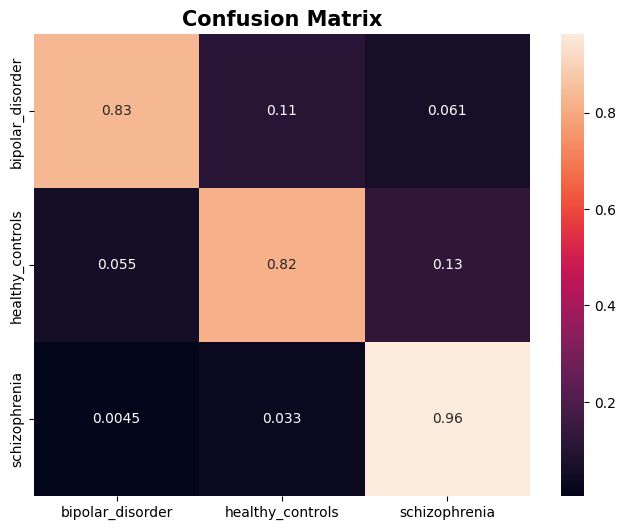

In [16]:
predicted = []  # predicted labels
true = []  # true labels

for image_batch, label_batch in test_dataset:  
    true.append(label_batch)
    prediction = model.predict(image_batch, verbose=0)
    predicted.append(np.argmax(prediction, axis=-1))

# convert labels into tensors
true_labels = tf.concat([item for item in true], axis=0)
predicted_labels = tf.concat([item for item in predicted], axis=0)

cf_matrix = confusion_matrix(true_labels, predicted_labels, normalize='true')

# plot confusion  matrix
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
sns.heatmap(cf_matrix, 
            annot=True)
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)
plt.title('Confusion Matrix', size=15, fontweight='bold')
plt.savefig('./CNN5_cm.png')
plt.show()

In [17]:
precision = precision_score(true_labels, predicted_labels, average='weighted')
sensitivity = recall_score(true_labels, predicted_labels, average='weighted')
specificity = []
for i in range(num_classes):
    true_negatives = np.sum(np.delete(np.delete(cf_matrix, i, axis=0), i, axis=1))
    false_positives = np.sum(cf_matrix[:, i]) - cf_matrix[i, i]
    specificity.append(true_negatives / (true_negatives + false_positives))

# Calculate average specificity
average_specificity = np.mean(specificity)

print("Accuracy:", result[1])
print("Precision:", precision)
print("Sensitivity:", sensitivity)
print("Specificity:", average_specificity)

Accuracy: 0.87060546875
Precision: 0.8746325228374181
Sensitivity: 0.87060546875
Specificity: 0.9355806448426557
